In [1]:
#Import packages
import os
import glob
import json
import pickle
import shutil
from pathlib import Path

#from tqdm import tqdm

import nilearn
import nibabel as nib
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage

from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix, run_glm
from nilearn.glm.second_level import make_second_level_design_matrix, SecondLevelModel
from nilearn.glm import fdr_threshold,threshold_stats_img
from nilearn.glm.contrasts import compute_contrast, _compute_fixed_effects_params
from bids.layout import BIDSLayout, parse_file_entities

# import cortex
# from cortex import fmriprep

from nipype.interfaces.workbench.base import WBCommand
from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch

import scipy.stats as stats

import hcp_utils as hcp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
#%matplotlib inline
#! module load openmind/hcp-workbench/1.2.3

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [30]:
#take all the first level files and parse out subject, session, and task name, remove repeats 

first_level_root = f'../../derivatives/first_level_110123'
first_level_effects = glob.glob(f'{first_level_root}/*effect_size*.dscalar.nii')
effect_variances = glob.glob(f'{first_level_root}/*effect_variance*.dscalar.nii')

#load list of runs to exclude and format as a list of bids-compliant names
exclude_df = pd.read_table('../../derivatives/first_level_110123/no_wall_of_speech_exclude_110123 - Sheet1.tsv')

exclude = []
for i, r in exclude_df.iterrows():
    sub = r['sub']
    ses = r['ses']
    task = r.iloc[5]
    run = r['run']
    exclude.append(f'sub-voice{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}')

#remove runs from exclusion list
effects_qc = [beta for beta in first_level_effects 
                      if beta.split('first_level_110123/')[1].split('_space')[0] not in exclude]
variance_qc = [beta for beta in effect_variances 
                      if beta.split('first_level_110123/')[1].split('_space')[0] not in exclude]

#get final list of sub/ses/tasks we want after fixed effects pooling
sub_ses_task_wdup = [sn.split('first_level_110123/')[1].split('_rec-unco')[0] for sn in effects_qc]
sub_ses_task = []
[sub_ses_task.append(x) for x in sub_ses_task_wdup if x not in sub_ses_task]
task_list = ['nwr','emosent']
sub_ses_task = [sst for task in task_list for sst in sub_ses_task  if task in sst]
len(sub_ses_task), len(effects_qc), len(variance_qc)

(96, 389, 389)

In [39]:
out_dir = '../../derivatives/second_level_110123'
#second_level_effects = {f:{t: [] for t in task_list} for f in fd_sweep}

#task_list = ['pataka', 'emosent', 'vowel', 'nwr']

second_level_effects = {t:[] for t in task_list}

for sst in sub_ses_task:
    effect_size_list = [file for file in effects_qc if sst in file]
    effect_var_list = [file for file in variance_qc if sst in file]

    if effect_size_list:
#         sub = parse_file_entities(effect_size_list[0])['subject'].split('voice')[1]
#         ses = parse_file_entities(effect_size_list[0])['session']
#         task = parse_file_entities(effect_size_list[0])['task']
        if len(effect_size_list) == 1:
            shutil.copy(effect_size_list[0], os.path.join(out_dir, str(Path(effect_size_list[0]).relative_to(first_level_root))))
            shutil.copy(effect_var_list[0], os.path.join(out_dir, str(Path(effect_var_list[0]).relative_to(first_level_root))))
            #second_level_effects[task].append(effect_size_list[0])
        elif len(effect_size_list) > 1:                
            fx_results = _compute_fixed_effects_params(
                np.squeeze(
                     [nib.load(fname).get_fdata(dtype='f4') for fname in effect_size_list]
                 ),
                 np.squeeze(
                     [nib.load(fname).get_fdata(dtype='f4') for fname in effect_var_list]
                 ),
                 precision_weighted=False)
            #note the order of fixed effects outputs: fx_results = [fixed_fx_contrast, fixed_fx_variance, fixed_fx_tstat]
            save_cifti(fx_results[0], 'effect_size_fx', out_dir, sst + '_rec-unco')
            save_cifti(fx_results[1], 'effect_variance_fx', out_dir, sst + '_rec-unco')
            save_cifti(fx_results[2], 'stat_fx', out_dir, sst + '_rec-unco')

In [4]:
def save_cifti(cifti_data, output_type, out_dir, sstr, sample_cifti_file='../../derivatives/fmriprep/sub-voice857/ses-1/smoothed/sub-voice857_ses-1_task-pataka_run-1_space-fsLR_den-91k_bold.dtseries.nii'):
    #takes 91k np array of parcels and generates cifti object
    
    sample_cifti = nimg.load_img(sample_cifti_file)
    time_axis, brain_model_axis = [sample_cifti.header.get_axis(i) for i in range(sample_cifti.ndim)]
    z = np.atleast_2d(cifti_data)
    scalar_axis = nib.cifti2.ScalarAxis([output_type])  # Takes a list of names, one per row
    new_header = nib.Cifti2Header.from_axes([scalar_axis, brain_model_axis])
    #z = np.reshape(z, (-1, z.shape[0]))
    img = nib.Cifti2Image(z, new_header)

    name = f'{out_dir}/{sstr}_space-fsLR_den-91k_contrast-spchsil_{output_type}.dscalar.nii'
    img.to_filename(name)
    return name

In [53]:
def fixed_effects(contrasts, variances):
    """Compute the fixed effects given arrays of effects and variance
    """
    tiny = 1.e-16
    con, var = np.asarray(contrasts), np.asarray(variances)
    var = np.maximum(var, tiny)
    prec = 1. / var
    ffx_var = 1. / np.sum(prec, 0)
    ffx_con = np.sum(con * prec, 0) * ffx_var
    ffx_stat = ffx_con / np.sqrt(ffx_var)
    return [ffx_con, ffx_var, ffx_stat]

In [ ]:
## I generated the fixed effects for everyone, even subjects with only 1 run. So the code to do that is commented out
# it should be generated by looping through the right set of files and calculating using the below or similar

#if effect_size_list:      
#             #this is from this example (https://github.com/individual-brain-charting/public_analysis_code/blob/master/ibc_public/utils_pipeline.py#L556)
#             #I did have to to change two lines
#             #For example it was con.append(np.ravel([darrays.data for darrays in load(con_img).darrays]))
#             #which I changed to con.append(np.ravel([darrays for darrays in load(con_img).get_fdata()]))
#             #and it seemed to work so I didn't question further
#             con, var = [], []
#             for (con_img, var_img) in zip(effect_size_list, effect_variance_list):
#                 con.append(np.ravel([
#                     darrays for darrays in load(con_img).get_fdata()]))
#                 var.append(np.ravel([
#                     darrays for darrays in load(var_img).get_fdata()]))

#             #This method is from the above link. It could be replaced by an implementation copied from fitlins
#             #e.g.:https://github.com/poldracklab/fitlins/blob/ec655c7ec71d92cc81141467bdb44e2bcc253425/fitlins/interfaces/nistats.py#L409-L432
#             #But I haven't compared them yet
#             contrast_output = fixed_effects(con, var)

#             #check that output does not exist
#             output = glob.glob(f'{out_dir}/second_level/sub-{sub}_ses-{ses}_task-{task}_effect_size_fx.dscalar.nii')
#             if output: #checks if list is not empty
#                 print(f'At least partial 1st level output exists for subject {sub}, session {ses} and task {task}. This must be deleted for before generating new output.')


#             #save contrast maps to files
#             #note the order of fixed effects outputs: fx_results = [fixed_fx_contrast, fixed_fx_variance, fixed_fx_tstat]
#             generate_zscore_cifti_object(contrast_output[0], f'{out_dir}/sub-{sub}_ses-{ses}_task-{task}_effect_size_fx.dscalar.nii')
#             generate_zscore_cifti_object(contrast_output[1],f'{out_dir}/sub-{sub}_ses-{ses}_task-{task}_effect_variance_fx.dscalar.nii')
#             generate_zscore_cifti_object(contrast_output[2], f'{out_dir}/sub-{sub}_ses-{ses}_task-{task}_stat_fx.dscalar.nii')
#             print(f'{sub} {task} {ses}: processing done')

In [50]:
#Save list of runs used for group analysis into one file.
with open("second_level_effects_wos_qc", "wb") as fp:   #Pickling
    pickle.dump(second_level_effects, fp)

In [5]:
# first_level_betas = glob.glob(f'../../derivatives/first_level/speech_v_silence_effects_size/*_fsLR_91k_speechvssilence_effect_size.dscalar.nii')

# #creates dict of runs from first level model based on being below an FD threshold
# low_motion = {}
# for fd in fd_sweep:
#     inclusion = qc_csv.bids_name[qc_csv.fd_mean <= fd]
#     inclusion = [i.split('_bold')[0] for i in inclusion]
#     low_motion[fd] = [beta for beta in first_level_betas 
#                   if beta.split('speech_v_silence_effects_size/')[1].split('_fsLR')[0] in inclusion]
# {f:len(files) for f, files in low_motion.items()}

{0.2: 91, 0.4: 261, 0.6: 366}

In [367]:
#looks at dict of low-motion runs per FD cutoff
#if a subject/session/task just has one run, we just use the first-level run
#if a subject/session/task has more than one run, the paths are stored to be combined using fixed effects

# out_dir = '../../derivatives/second_level'
# second_level_effects = {f:{t: [] for t in task_list} for f in fd_sweep}

# for fd, lm in low_motion.items():
#     for sub in sub_ses_task:
#         effect_size_list = [file for file in lm if sub in file]
        
#         if effect_size_list:
#             sub = parse_file_entities(effect_size_list[0])['subject'].split('voice')[1]
#             ses = parse_file_entities(effect_size_list[0])['session']
#             task = parse_file_entities(effect_size_list[0])['task']

#             if len(effect_size_list) == 1:
#                 second_level_effects[fd][task].append(effect_size_list[0])
#             elif len(effect_size_list) > 1:
#                 second_level_effects[fd][task].append(
#                     f'{out_dir}/sub-{sub}_ses-{ses}_task-{task}_effect_size_fx.dscalar.nii')


In [368]:
#create a per task/FD cutoff count of the number of runs
#this number should (?) increase as cutoff increaes less conservative
# pd.DataFrame({t:{fd: len(val) for fd, val in files.items()} for t, files in second_level_effects.items()})

,0.2,0.4,0.6
vowel,6,27,38
nwr,25,47,50
emosent,13,36,47
pataka,5,26,47


In [369]:
# #Save list of runs used for group analysis into one file.
# with open("second_level_effects_FD_sweep", "wb") as fp:   #Pickling
#     pickle.dump(second_level_effects, fp)

In [23]:
# #tests we can open and use the data as expected
# with open("second_level_effects", "rb") as fp:   # Unpickling
#     b = pickle.load(fp)

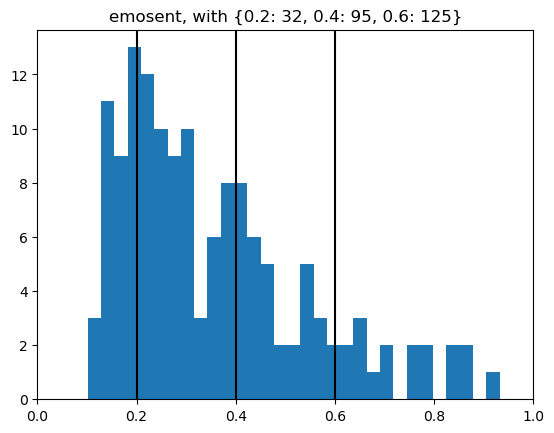

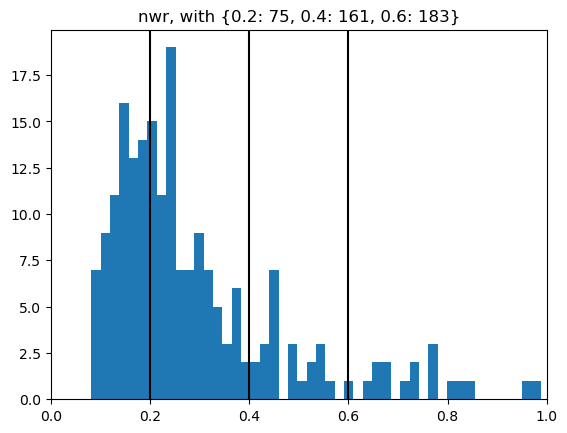

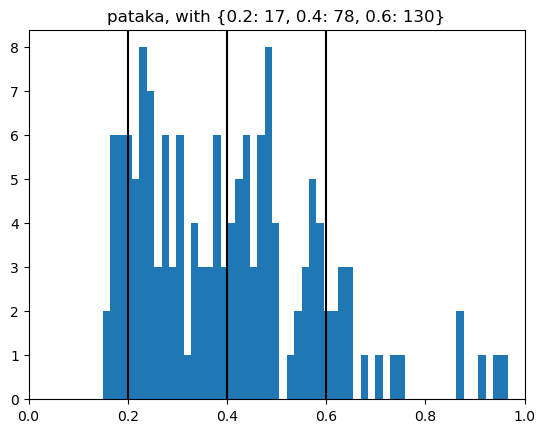

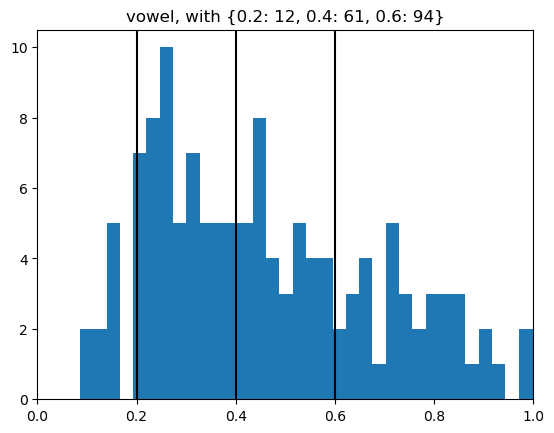

In [7]:
#quantifying number of files per task per cutoff

task_list = ['vowel', 'nwr', 'emosent','pataka']
qc_relevant_tasks = qc_csv[qc_csv.task.isin(task_list)]

for t, d in qc_relevant_tasks.groupby('task'):
    count = {round(fd, 1):d[d.fd_mean<=fd].shape[0] for fd in fd_sweep}
    
    plt.hist(d.fd_mean, bins=100
            )
    plt.xlim([0, 1])
    xcoords = [0.2, 0.4, 0.6]
    for xc in xcoords:
        plt.axvline(x=xc, color='k')
    plt.title(f'{t}, with {count}')
    plt.show()